In [ ]:
#default_exp distributions

# distributions

> This module defines a base class `DistributionDefinitions` that supplies the `ModelBase` with information about default probability distributions, along with additional class and functions for working with distributions 

In [ ]:
#export
import numpy, scipy
import scipy.stats
from jax import scipy as jsc
from jax import numpy as jnp
import jax
from abc import ABC, abstractmethod, abstractproperty
from jax import jit


from amppl.math import chooseln, gammaln, factor_toeplitz, log_expit
from amppl.utilities import switch

In [ ]:
#hide 
from matplotlib import pyplot
import seaborn
from tqdm import tqdm

A distribution can be assigned to several categories based on the ways in which its random variables are constrained. First, a distribution can be divided into either

    A. continuous
    B. discrete
In each of these categories, distributions can be further divided

1. Unbounded: Values range from $-\infty$ to $\infty$
2. Half-bounded: Values range from either $(A,\infty]$ or $[-\infty,B)$ 
3. Fully bounded: Values range from $(A,B)$

# Bijections
When optimizing a model, the simplest optimization algorithms require that the search space be unconstrained. So when working with the parameters of a distribution, we need to define the rules for moving between potentially constrained parameter spaces and unconstrained transformations of those parameter. While these are used by the `Distribution` class, in general it shouldn't be necessary to directly work with these classes.

In [ ]:
#export
class Bijection(ABC):
    """A base class decribing the structure of a bijection. Convertes between constrained and \
    unconstrained representations of a parameter"""
    @abstractmethod
    def unconstrained(self,x):
        """The given the constrained representation, return the unconstrained version"""
        pass
    @abstractmethod
    def constrained(self,x):
        """The given the unconstrained representation, return the constrained version"""
        
        pass
    def jacobian(self,x):
        pass
    

In [ ]:
#export
class Unbounded(Bijection):
    """A bijection for unconstrained distributions, i.e. the identity link."""
    def __init__(self,):
        self.lowerbound=-jnp.inf
        self.upperbound=jnp.inf
        pass
    def unconstrained(self,x):
        return x
    def constrained(self,x):
        return x
    def jacobian(self,x):
        return jnp.ones(x.shape)
    def log_jacobian(self, x):
        return jnp.zeros(x.shape)
#         return 
    

In [ ]:
#export
class HalfBounded(Bijection):
    """A bijection for half-bounded distributions, i.e. the log link.
        Arguments:
            A (float) - The parameter's lower bound (-jnp.inf is no lower bound)
            B (float) - The parameter's upper bound (jnp.inf is no upper bound)
            
            One of A and B must be finite and the other infinite"""
    def __init__(self, A,B):
        self.lowerbound=A
        self.upperbound=B
        if jnp.isinf(A)==True and jnp.sign(A)==-1:
            self.sign=jnp.sign(A)
            self.offset=B
        elif jnp.isinf(B)==True and jnp.sign(B)==1:
            self.sign=jnp.sign(B)
            self.offset=A
        else:
            raise ValueError
        
    def unconstrained(self,x):
        z=self.sign*(x-self.offset)
        return jnp.log(z)
    def constrained(self,x):
        z=jnp.exp(x)
        return z/self.sign+self.offset
    def jacobian(self,x):
        return 1./x
    def log_jacobian(self,x):
        return -jnp.log(x)

In [ ]:
#export
class Bounded(Bijection):
    """A bijection for fully bounded distributions, i.e. the logit link.
    Arguments:
        A (float) - The parameter's lower bound
        B (float) - The parameter's upper bound

        Note: Both A and B must be finite"""
    def __init__(self,A,B):
        self.lowerbound=A
        self.upperbound=B
        self.A=A
        self.B=B
    def unconstrained(self,x):
        z=(x-self.A)/(self.B-self.A)
        return jsc.special.logit(z)
    def constrained(self,x):
        z=(self.B-self.A)*jsc.special.expit(x)+self.A
        return z
    def jacobian(self,x):
        z=(x-self.A)/(self.B-self.A)
        return (1./(z*(1-z)))*(1./(self.B-self.A))
    def log_jacobian(self,x):
        
        z=(x-self.A)/(self.B-self.A)

        return -jnp.log(z)-jnp.log(1-z)-jnp.log(self.B-self.A)
#         return jnp.log(self.B - self.A) - jnp.log(x-self.A) - jnp.log(self.B-x)  
    

In [ ]:
def test1(x,A,B):
    z=(x-A)/(B-A)
    return (1./(z*(1-z)))*(1./(B-A))
def test2(x,A,B):
    return (A-B)/((A-x)*(B-x))
print(test1(-1, -4, 0))
print(test2(-1, -4, 0))

1.3333333333333333
1.3333333333333333


In [ ]:
#export
class Simplex(Bijection):
    def __init__(self,B=1):
        """A bijection for distributions over points on a simplex. The sum of vector
        on the simplex equals B.
        
        ****
        **Arguments:**
        
        `B` (float > 0) """
        self.lowerbound=0
        self.upperbound=B
        self.A=0
        self.B=B
    def unconstrained(self,x):
        B=x.sum(-1)
        z=jnp.log(x)-jnp.log(B)
        return z
    def constrained(self,x):
        z=self.B*(jnp.exp(x))/jnp.exp(x).sum(-1) 
        return z


# Defining distributions

Distributions are defined by some set of possible outcomes and a log-probability function that assigns each of those possible outcomes a log-probability. These properties are represented by the `Distribution` base class. 

In [ ]:
#export
class Distribution(ABC):
    """The base class for defining probability distributions.
        Arguments:
            logp (callable) - The log-probability functions (must be compatible with JAX gradients)
            lowerbound (float) - The lower bound of the distribution's domain
            upperbound (float) - The upper bound of the distribution's domain
            kind (str) - Either 'continuous' or 'discrete'. Currently does nothing, but here for 
                future use
            rvs (callable) - A random variable generator. Should take the same parameters as the logpdf (optional)
            bijection (Bijection subclass): An explicitly defined bijection
            """
    def __init__(self, logp=lambda x: numpy.nan,
                 lowerbound=-numpy.inf, 
                 upperbound=numpy.inf,
                 kind='continuous', 
                 rvs=None,
                 cdf=None,
                bijection=None, *args, **kwargs):
        self.lowerbound=lowerbound
        self.upperbound=upperbound
#         self.logp=jit(logp)
        self.logp=logp
        self.cdf=cdf
        self.rvs=rvs
        if isinstance(bijection, type(None)):
            self._assign_bijection()
        else:
            self.bijection=bijection
    
    def _assign_bijection(self):
        
        lbound=self.lowerbound
        ubound=self.upperbound
        self.bijection=self._determine_bijection(lbound, ubound)
        
    def _determine_bijection(self, lbound, ubound):
        if numpy.isinf(lbound)!=numpy.isinf(ubound):
            return HalfBounded(lbound,ubound)
        elif numpy.isinf(lbound)==True and numpy.isinf(ubound)==True:
            return Unbounded()
        elif numpy.isinf(lbound)==False and numpy.isinf(ubound)==False:
            return Bounded(lbound, ubound)
        
    def logp(self, x, *args, **kwargs):
        # Might make sense to update this to return 0 for any X outside of the defined bounds
        # If continuous A<X<B
        # If discrete A<=X<=B
        self.logp(x, *args, **kwargs)
    
    def rvs(self, *args, **kwargs):
        self.rvs( *args, **kwargs)
        
    def value(self, value, *args, **kwargs):
        return value



# Need-to-change

I need to think more about and probably change how I handle the shapes of the distributions. Basically, the .rvs method of multivariate distributions works differently than for univariate. Also, distributions on the simplex require fewer unconstrained parameters. So, I think something about #unconstrained ->  #constrained is necessary. And something tht can handle the needs of multivariate RVs.

The lower and upper bounds defined for the distribution determine the bijection for transforming random variables to and from the unconstrained space.

# Unbounded distributions

## Continuous

In [ ]:
#export
class Flat(Distribution):
    """A flat improper prior"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=lambda x:0,
                        rvs=None)

In [ ]:
#export
class Normal(Distribution):
    """The normal distribution"""
    logpdf=jsc.stats.norm.logpdf
    random=scipy.stats.norm.rvs
    def __init__(self, *args, **kwargs):
        super().__init__(logp=jsc.stats.norm.logpdf,
                        rvs=scipy.stats.norm.rvs,
                        cdf=jsc.stats.norm.cdf)
        


(-4.0, 4.0)

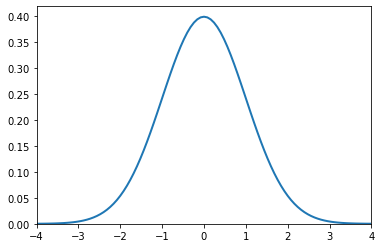

In [ ]:
norm_dist=Normal()
xmin,xmax=-4,4
xvals=numpy.linspace(xmin,xmax,101)
pyplot.plot(xvals,numpy.exp(norm_dist.logp(xvals, loc=0, scale=1)), lw=2)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export
def logistic_logpdf(x, loc=0,scale=1):
    u=.5*(x-loc)/scale
    
    
    

In [ ]:
#export
class Logistic(Distribution):
    """The logistic distribution"""
    logpdf=jsc.stats.norm.logpdf
    random=scipy.stats.norm.rvs
    def __init__(self, *args, **kwargs):
        super().__init__(logp=jsc.stats.logistic.logpdf,
                        rvs=scipy.stats.logistic.rvs,)
        

In [ ]:
jsc.stats.logistic.logpdf(0)

DeviceArray(-1.3862944, dtype=float32)

In [ ]:
example_dist=Logistic()
xmin,xmax=-4,4
xvals=numpy.linspace(xmin,xmax,101)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals, 0, 1)), lw=2)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

TypeError: logpdf() takes 1 positional argument but 3 were given

In [ ]:
t=Normal()
t.logp(1,2,3)

DeviceArray(-2.0731065, dtype=float32)

In [ ]:
#export 
        
class StudentT(Distribution):
    """The Student T distribution, using the scipy parameterization"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=jsc.stats.t.logpdf,
                         rvs=scipy.stats.t.rvs)

(-4.0, 4.0)

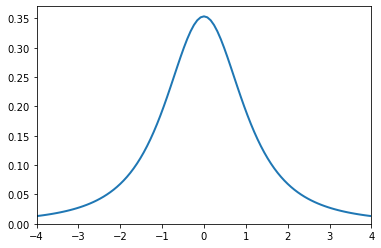

In [ ]:
example_dist=StudentT()
xmin,xmax=-4,4
xvals=numpy.linspace(xmin,xmax,101)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals, loc=0, scale=1, df=2)), lw=2)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export
def spikeandslab_norm_logpdf(x, mu=0,frac=.5, spike_sd=.1, slab_sd=2, *args, **kwargs,):
    spike_logp=jnp.log(1-frac)+ jsc.stats.norm.logpdf(x, loc=mu, scale=spike_sd)
    slab_logp=jnp.log(frac)+ jsc.stats.norm.logpdf(x, loc=mu, scale=spike_sd+slab_sd)
    logps=jnp.vstack([spike_logp, slab_logp])
    
    return jsc.special.logsumexp(logps, axis=0)

def spikeandslab_norm_rvs( mu=0,frac=.5, spike_sd=.1, slab_sd=2, size=1):
    z=scipy.stats.bernoulli.rvs(frac, size=size)
    x=numpy.ones(size)
    x[z==0]+=scipy.stats.norm.rvs(loc=mu, scale=spike_sd, size=(z==0).sum())
    x[z==1]+=scipy.stats.norm.rvs(loc=mu, scale=spike_sd+slab_sd, size=(z==1).sum())
    
    return x

In [ ]:
#export
class SpikeAndSlabNormal(Distribution):
    """A spike-and-slab mixture of normal distributions"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=spikeandslab_norm_logpdf,
                        rvs=spikeandslab_norm_rvs)
        

(-4.0, 4.0)

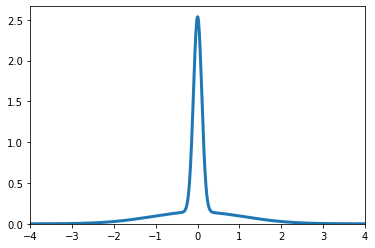

In [ ]:
example_dist=SpikeAndSlabNormal()
xmin,xmax=-4,4
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,
                                              mu=0, 
                                              frac=.4, 
                                              spike_sd=.1, 
                                              slab_sd=1)), lw=3)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export

def mv_norm_rvs(mean, cov, size):
    return scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov,size=size)

class MultivariateNormal(Distribution):
    """The multivariate normal distribution, uses the scipy parameterization"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=jsc.stats.multivariate_normal.logpdf,
                        rvs=mv_norm_rvs)
    def compute_covariance(self,mean, cov, *args, **kwargs):
        return cov

(1000, 2)


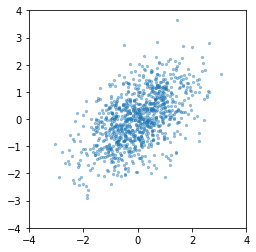

In [ ]:
example_dist=MultivariateNormal()
xmin,xmax=-4,4
xvals=numpy.linspace(xmin,xmax,1001)
cov=numpy.array([[1,.5],
                                         [.5,1]])
sample=example_dist.rvs(mean=numpy.array([0,0]), cov=cov, size=(1000))
print(sample.shape)
pyplot.scatter(sample[:,0], sample[:,1],s=5, alpha=.4)
pyplot.xlim(xmin,xmax)
pyplot.ylim(xmin,xmax)
gca=pyplot.gca().set_aspect('equal')

The multivariate normal pdf is 

$$p(x;\mu, \Sigma)=det(2\pi\Sigma)^{-\frac{1}{2}} exp \left[-\frac{1}{2} (x-\mu)^T\Sigma^{-1}(x-\mu) \right]$$

Alternatively, it may often be more efficient to write this in terms of the Cholesky matrix, or the Cholesky of the correlation matrix and the marginal variance. That is

$$\Sigma=LL^T$$

Let's substitute in $w=x-\mu$, and we have

$$p(x;\mu, LL^T)=det(2\pi LL^T)^{-\frac{1}{2}} exp \left[-\frac{1}{2} w^T (LL^T)^{-1} w \right]$$

$$=det(2\pi LL^T)^{-\frac{1}{2}} exp \left[-\frac{1}{2} w^T(LL^T)^{-1}w \right]$$

$$=det(2\pi LL^T)^{-\frac{1}{2}} exp \left[-\frac{1}{2} w^T(LL^T)^{-1}w \right]$$

$$=det(2\pi LL^T)^{-\frac{1}{2}} exp \left[-\frac{1}{2} (L^{-1}w)^T L^{-1}w \right]$$

$$=det(2\pi LL^T)^{-\frac{1}{2}} exp \left[-\frac{1}{2} z^Tz \right]$$

where 

$$z=L^{-1}w$$

In [ ]:
def multivariate_normal_chol_logpdf(x, mean,scale,chol ):
    """Multivariate normal distribution parameterized with a full-rank cholesky"""
    L_inv=jnp.linalg.pinv(chol)
    w=(x-mean)/scale
    z=L_inv@w

    cov=chol@chol.T

#     return (-jnp.log(jnp.diag(2*jnp.pi*chol)).sum() -
#             (.5*z**2).sum())
    return ( -.5*len(mean)*jnp.log(2*jnp.pi)-jnp.log(jnp.diag(chol)).sum() -
            (.5*z**2).sum())
    
    
    

In [ ]:
#export
def multivariate_normal_chol_logpdf(x, mean,scale,chol ):
    """A cholesky-based implementation of the MvNormal distribution. Assumes that the marginal 
    standard deviation is the same for all axes and that the Cholesky matrix describes the correlation
    structure
    ****
    **Arguments:**
    
    `x` ((M) or (N,M) array of observations): The observations to compute the probabilities for, where M \
    is the number of dimensions of the MvNormal distribution and N is the number of samples
    
    `mean` (M length array): The mean of the MvNormal distribution
    
    `scale` (N length array): The scale of the MvNormal distribution
    
    `chol` (M-by-M lower triangular array): The lower Cholesky of the correlation matrix
    
    
    """
    L_inv=jnp.linalg.pinv(chol)
    try:
        w=(x-mean)/scale[:,None]
    except:
        w=(x-mean)/scale
    z=jnp.tensordot(L_inv,w, axes=(-1,-1)).T

    cov=chol@chol.T
    return ( len(mean)*(-.5*jnp.log(2*jnp.pi)-jnp.log(scale))-jnp.log(jnp.diag(chol)).sum(-1) -
            (.5*z**2).sum(-1))
    

In [ ]:
#export
def multivariate_normal_chol_rvs( mean,scale,chol, size ):
    """A cholesky-based implementation of the MvNormal distribution. Assumes that the marginal 
    standard deviation is the same for all axes and that the Cholesky matrix describes the correlation
    structure
    ****
    **Arguments:**
    
    `x` ((M) or (N,M) array of observations): The observations to compute the probabilities for, where M \
    is the number of dimensions of the MvNormal distribution and N is the number of samples
    
    `mean` (M length array): The mean of the MvNormal distribution
    
    `scale` (N length array): The scale of the MvNormal distribution
    
    `chol` (M-by-M lower triangular array): The lower Cholesky of the correlation matrix
    
    
    """
    z=scipy.stats.norm.rvs(0,1,size=size)
    x= jnp.array(scale)[:,None]*jnp.tensordot(chol,z, axes=(-1,-1)).T+mean[None,:]
    return x

In [ ]:
#export
class CholeskyMvNormal(Distribution):
    """The multivariate normal distribution, uses a Cholesky-scale (LDL) parameterization"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=multivariate_normal_chol_logpdf,
                        rvs=multivariate_normal_chol_rvs)
    def compute_covariance(self,mean, chol, scale, *args, **kwargs):
        cov=(chol@chol.T)*scale**2
        return cov
        

# Half-bounded distributions

## Continuous

In [ ]:
#export
class HalfFlat(Distribution):
    def __init__(self,*args, **kwargs):
        """A HalfFlat improper prior"""
        super().__init__(logp=lambda x:0,
                         rvs=scipy.stats.gamma.rvs,
                         lowerbound=0,)

NameError: name 'Markdown' is not defined

In [ ]:
#export
class Gamma(Distribution):
    def __init__(self, *args, **kwargs):
        """The gamma distribution. Uses the scipy location-shape-scale parameterization"""
        
        super().__init__(logp=jsc.stats.gamma.logpdf,
                         rvs=scipy.stats.gamma.rvs,
                         lowerbound=0,)


(0.0, 6.0)

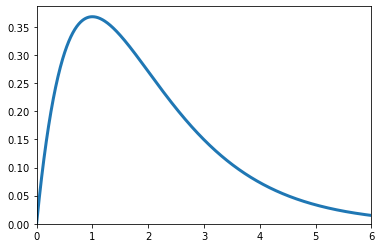

In [ ]:
example_dist=Gamma()
xmin,xmax=0,6
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,
                                              a=2, scale=1,)), lw=3)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export

def halfnormal_logpdf(x, scale=1):
    return jnp.log(2)+jsc.stats.norm.logpdf(x, loc=0, scale=scale)
def halfnormal_rvs(x, scale=1,size=1):
    return jnp.abs(scipy.stats.norm.rvs(0,scale,size))
class HalfNormal(Distribution):
    def __init__(self, *args, **kwargs):
        """A Half Normal distribution. 
        ****
        **Parameters:**
        
        `scale` (>0)"""
        
        super().__init__(logp=halfnormal_logpdf,
                         rvs=halfnormal_rvs,
                         lowerbound=0,)

(0.0, 6.0)

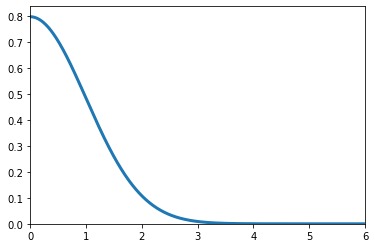

In [ ]:
example_dist=HalfNormal()
xmin,xmax=0,6
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,
                                               scale=1,)), lw=3)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export

def halfT_logpdf(x, scale=1, df=1):
    return jnp.log(2)+jsc.stats.t.logpdf(x, loc=0, scale=scale, df=df)
def halfT_rvs(x, scale=1,df=1,size=1):
    return jnp.abs(scipy.stats.t.rvs(loc=0,scale=scale,df=df,size=size))
class HalfStudentT(Distribution):
    def __init__(self, *args, **kwargs):
        """A Half StudentT distribution. 
        ****
        **Parameters:**
        
        `scale` (>0)
        `df` (>0)"""
        super().__init__(logp=halfT_logpdf,
                         rvs=halfT_rvs,
                         lowerbound=0,)

(0.0, 6.0)

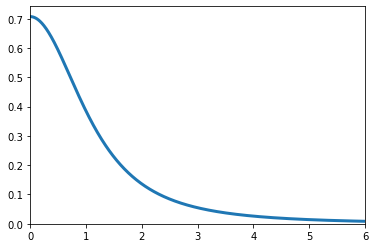

In [ ]:
example_dist=HalfStudentT()
xmin,xmax=0,6
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,
                                               scale=1,df=2)), lw=3)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export

# def invgamma_logpdf(x, a=1,scale=1):
#     """The inverse-gamma logpdf. A change of variable transformation of the gamma distribution.
#     Uses the gamma distribution's location-shape-scale parameterization"""
# #     return jsc.stats.gamma.logpdf(x,*args, **kwargs)-jnp.log(x)
#     alpha=a
#     beta=scale
#     return  (alpha*jnp.log(beta)-jsc.special.gammaln(alpha)+
#              (-alpha-1)*jnp.log(x)-beta/x)


def invgamma_logpdf(x, a=1,scale=1):
    """The inverse-gamma logpdf. A change of variable transformation of the gamma distribution.
    Uses the gamma distribution's location-shape-scale parameterization"""
#     return jsc.stats.gamma.logpdf(x,*args, **kwargs)-jnp.log(x)
    alpha=a
    beta=scale
    return  (alpha*jnp.log(beta)-jsc.special.gammaln(alpha)+
             (-alpha-1)*jnp.log(x)-beta/x)
             
class InverseGamma(Distribution):

    def __init__(self, *args, **kwargs):
        """The inverse-gamma distribution. Uses the scipy location-shape-scale parameterization
        ****
        **Parameters:**
        
        `a` (>0): Shape parameter
        `scale` (>0)"""
        
        super().__init__(logp=invgamma_logpdf,
                         rvs=scipy.stats.invgamma.rvs,
                         lowerbound=0,)

<ipython-input-113-5e2031685316>:20: RuntimeWarning: divide by zero encountered in true_divide
  (-alpha-1)*jnp.log(x)-beta/x)


(0.0, 6.0)

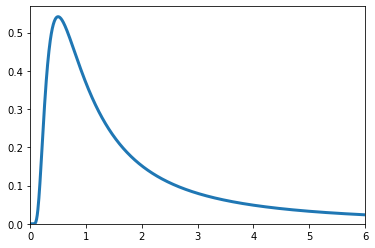

In [ ]:
example_dist=InverseGamma()
xmin,xmax=0,6
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,
                                               scale=1,)), lw=3)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
def loginvgamma_logpdf(x, *args, **kwargs):
    """The inverse-gamma logpdf. A change of variable transformation of the gamma distribution.
    Uses the gamma distribution's location-shape-scale parameterization"""
    u=jnp.exp(x)
    return x+jsc.stats.gamma.logpdf(u,*args, **kwargs)-u
class LogInverseGamma(Distribution):
    """The inverse-gamma distribution. Uses the scipy location-shape-scale parameterization"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=invgamma_logpdf,
                         rvs=scipy.stats.invgamma.rvs,
                         lowerbound=0,)

In [ ]:
#export
class Expon(Distribution):
    """The exponential distribution. Uses the scipy location-scale parameterization"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=jsc.stats.expon.logpdf,
                         rvs=scipy.stats.expon.rvs,
                         lowerbound=0,)
        

(0.0, 6.0)

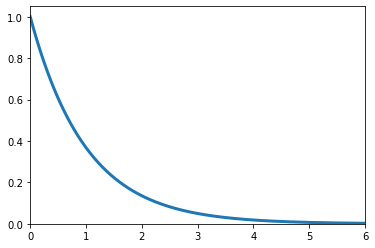

In [ ]:
example_dist=Expon()
xmin,xmax=0,6
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,
                                               scale=1,)), lw=3)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export 
def gengamma_logpdf(x,a,d,p):
    """The generalized gamma logpdf"""
    return -gammaln(d/p)+jnp.log(p)-d*jnp.log(a)+(d-1)*jnp.log(x)-(x/a)**p

def gengamma_rvs(a,d,p,size=1):
    theta=a**(p)
    k=d/p
    return scipy.stats.gamma.rvs(a=d/p, scale=theta,size=size)**(1/p)
    
class GenGamma(Distribution):
    """The gamma distribution. Uses the scipy location-shape-scale parameterization"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=gengamma_logpdf,
                         rvs=gengamma_rvs,
                         lowerbound=0,)


(0.0, 6.0)

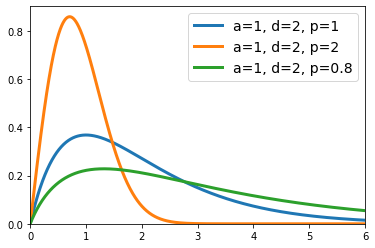

In [ ]:
example_dist=GenGamma()
xmin,xmax=0,6
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,d=2, p=1,)), lw=3, label="a=1, d=2, p=1")
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,d=2, p=2,)), lw=3, label="a=1, d=2, p=2")
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,d=2, p=.8,)), lw=3, label="a=1, d=2, p=0.8")

pyplot.legend(fontsize=14)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export 
def invgengamma_logpdf(x,a,d,p):
    """The generalized gamma logpdf"""
    return -2*jnp.log(x)-gammaln(d/p)+jnp.log(p)-d*jnp.log(a)+(d-1)*jnp.log(1./x)-(x*a)**-p
def invgengamma_rvs(a,d,p,size=1):
    return 1./gengamma_rvs(a,d,p,size)

class InvGenGamma(Distribution):
    """The gamma distribution. Uses the scipy location-shape-scale parameterization"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=invgengamma_logpdf,
                         rvs=invgengamma_rvs,
                         lowerbound=0,)

(0.01, 6.0)

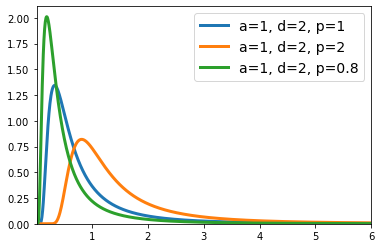

In [ ]:
example_dist=InvGenGamma()
xmin,xmax=0.01,6
xvals=numpy.linspace(xmin,xmax,1001)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,d=2, p=1,)), lw=3, label="a=1, d=2, p=1")
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,d=2, p=2,)), lw=3, label="a=1, d=2, p=2")
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,d=2, p=.8,)), lw=3, label="a=1, d=2, p=0.8")

pyplot.legend(fontsize=14)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

In [ ]:
#export 
def inv_gamma_tail(x, beta):
    return jnp.exp(-beta/x)

def gen_gamma_tail(x,a,d,p):
    return jnp.exp((d-1)*jnp.log(x)-(x/a)**p)

def hybrid_dist(x, a,d,p,b):
    return inv_gamma_tail(x,b)*gen_gamma_tail(x,a,d,p)

def compute_normalizing_constant(a,d,p,b, epsabs=1e-6, epsrel=1e-6):
#     try:
    return scipy.integrate.quad(hybrid_dist,a=0, b=numpy.inf,args=(a,d,p,b), epsabs=epsabs, epsrel=epsrel)[0]
#     except:
#         size=len(a)
#         Zs=[]
#         for i in range(size):
#             Zs.append(jsc.integrate.quad(dist,a=0, b=numpy.inf,args=(a[i],d[i],p[i],b[i]), epsabs=epsabs, epsrel=epsrel)[0])
#         return numpy.array(Zs)
    
def hybrid_log_unnormalized(x, a,d,p, b):

    return (d-1)*jnp.log(x)-(x/a)**p-b/x




In [ ]:
#export

# import numpy
def gengammarvs(a,d,p, size=1):
    theta=a**(p)
    k=d/p
    return scipy.stats.gamma.rvs( a=k, 
            scale=theta, 
            size=size)**(1/p)
def get_flattened_size(shape):
    size=1
    for dim in shape:
        size*=dim
    return int (size)
def invgamma_gengamma_rejection_sampler(a,d,p,b, size=1):
    """Use rejection sample to generate a sample from the distribution proportional to
            gengamma(x; a,d,p)*exp(-b/x)
        Arguments:
            a,d,p (float > 0) - The parameters of the the generalized gamma distribution
            b (float > 0) - The decay rate of the inverse-gamma left tail
            size (int > 0)"""
                
    def build_rejection_sample(initial_sample,a,d,p,b,size):
        proposal_size=size-len(initial_sample)

        proposal=gengammarvs(a,d,p,proposal_size)
        acceptance_probability=inv_gamma_tail(proposal,b)

        accepted_indices=scipy.stats.bernoulli.rvs(acceptance_probability)==1
#         print (accepted_indices)
        accepted_sample=proposal[accepted_indices]
        if len(accepted_sample)>1:
            accepted_sample=list(accepted_sample)
        elif len(accepted_sample)==1:
            accepted_sample=[float(accepted_sample[0])]
        else:
            accepted_sample=[]
    
        new_sample=initial_sample+accepted_sample
        if len(new_sample)!=size:

            new_sample=build_rejection_sample(new_sample,a,d,p,b,size,)
        
        return new_sample
    
    def construct_sample_for_parameters(a,d,p,b, size):
        if isinstance(size, tuple):
            flat_size=get_flattened_size(size)

        else: 
            flat_size=size

        initial_sample=[]


        return jnp.array(build_rejection_sample(initial_sample, a,d,p,b, flat_size)).reshape(size)
    
    try: 
        if len(a)>1:
            sample=[]
            for i in range(len(a)):
                a_i,d_i,p_i,b_i=a[i],d[i],p[i],b[i]
                size_i=size[0]
                sample.append(construct_sample_for_parameters(a_i,d_i,p_i,b_i,size_i))
            sample=jnp.vstack(sample).T
        else:
            sample=construct_sample_for_parameters(a,d,p,b,size)
    except:
        sample=construct_sample_for_parameters(a,d,p,b,size)
    return sample
                

In [ ]:
#export
class HybridGenGamma(Distribution):
    """A convolution between a generalized gamma distribution with parameters \
    a, d, and p, and the left tail of an inverse gamma distribution with scale b. \
    Note that the parameters a, d, p, and b must be fixed."""
    def __init__(self,a,d,p,b, *args, **kwargs):
        self.Z=jnp.log(compute_normalizing_constant( a,d,p, b))
        self.a=a
        self.d=d
        self.b=b
        self.p=p
        super().__init__(logp=self.compute_logpdf,
                         rvs=self.random_sample,
                         lowerbound=0,)
    def compute_logpdf(self,x, a=True,d=True,p=True,b=True):
        a,d,p,b=self._get_parameters(a,d,p,b)
        return hybrid_log_unnormalized(x,a,d,p,b)-self.Z
    def random_sample(self, a=True,d=True,p=True,b=True, size=1):
        a,d,p,b=self._get_parameters(a,d,p,b)
        return invgamma_gengamma_rejection_sampler(a,d,p,b,size)
    def _get_parameters(self, a,d,p,b):
        a=switch(a, self.a, a)
        d=switch(d, self.d, d)
        p=switch(p, self.p, p)
        b=switch(b, self.b, b)
        return a, d, p ,b
        
        

By multiplying the GenGamma by $\frac{1}{exp\left(\frac{b}{x}\right)}$, we strongly squish the distribution's density near zero. For example, the generalized gamma $GG(1,1,1)$ has its mode at zero. The HGG(1,1,1,1), however, does not.

<ipython-input-143-06c14730e576>:23: RuntimeWarning: divide by zero encountered in true_divide
  return (d-1)*jnp.log(x)-(x/a)**p-b/x


(0.0, 6.0)

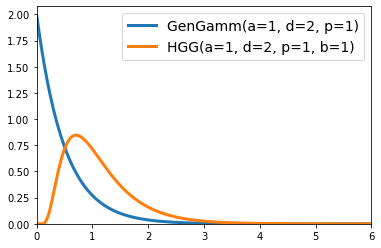

In [ ]:
xmin,xmax=0,6
xvals=numpy.linspace(xmin,xmax,1001)
example_dist=GenGamma()

pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=.5,d=1, p=1,)), lw=3, label="GenGamm(a=1, d=1, p=1)")

example_dist=HybridGenGamma(a=.5,d=1, p=1,b=1)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals)), lw=3, label="HGG(a=1, d=1, p=1, b=1)")



pyplot.legend(fontsize=14)
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

This convolution needs to be normalized to create a proper distribution. There isn't a closed form solution for the integral, and numerical integration is required. Because of this, the parameters of the distribution cannot treated as random variables and must be fixed when the model is defined. Whenever a `HybridGenGamma` variable is created, the parameters must be passed at initialization:

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


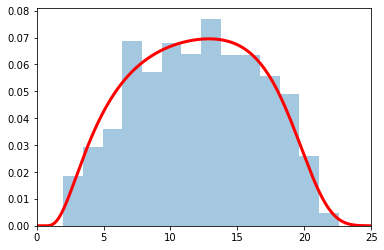

In [ ]:
hgg=HybridGenGamma(20.,.5,10.,8.)
rv=hgg.rvs( size=(1000))
x=numpy.linspace(.001, 25, 1001)
seaborn.distplot(rv, norm_hist=True, kde=False)
pyplot.plot(x,numpy.exp(hgg.logp(x)) , c='r', lw=3)
xlim=pyplot.xlim(0,25)

## Discrete

In [ ]:
#export
class Poisson(Distribution):
    """The Poisson distribution"""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=jsc.stats.poisson.logpmf,
                         rvs=scipy.stats.poisson.rvs,
                         kind='discrete',
                         lowerbound=0,)


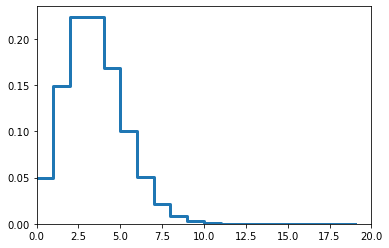

In [ ]:
example_dist=Poisson()
xmin,xmax=0,20
xvals=numpy.arange(0,xmax)
pyplot.step(xvals,numpy.exp(example_dist.logp(xvals,3)),where='post', lw=3)
pyplot.ylim(0)
xlim=pyplot.xlim(xmin,xmax)

In [ ]:
# export

@jit
def negative_binom_logpmf(x, mu, a=None, disp=None):
    """The negative-binomial logpdf.
        Arguments:
            x (int, >=0) - The observation
            mu (float, must be greater than 0) - The mean of the distribution
            a (float >0) - The shape parameter of the gamma distribution on the Poisson rate parameter
            disp (float >1) - The Variance/Mean of the distribution (may be easier to think about than `a`)"""
#     assert (isinstance(a, type(None))&isinstance(disp, type(None)))==False
# #     assert (isinstance(a, type(None))==False&isinstance(disp, type(None))==False)==False
#     if isinstance(disp, type(None))==False:
#         a=mu/(disp-1)
    a=mu/(disp-1)
    return (chooseln(x+a-1, x)+
            a*jnp.log(a)-
            a*jnp.log(mu+a)+
            x*jnp.log(mu)-
            x*jnp.log(mu+a))
    
class NegativeBinomial(Distribution):
    """The negative-binomial distribution."""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=negative_binom_logpmf,
                         rvs=scipy.stats.nbinom.rvs,
                         kind='discrete',
                         lowerbound=0,)

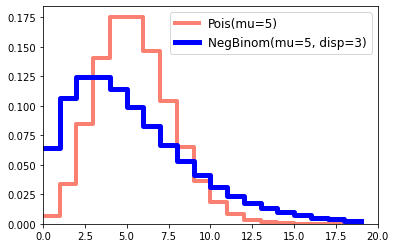

In [ ]:
example_dist=Poisson()
xmin,xmax=0,20
xvals=numpy.arange(0,xmax)
pyplot.step(xvals,numpy.exp(example_dist.logp(xvals,5)),where='post',c='salmon', lw=4, label='Pois(mu=5)')
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)
example_dist=NegativeBinomial()
xmin,xmax=0,20
xvals=numpy.arange(0,xmax)
pyplot.step(xvals,numpy.exp(example_dist.logp(xvals,mu=5, disp=3)),where='post',c='blue', lw=5, label='NegBinom(mu=5, disp=3)')
pyplot.ylim(0)
pyplot.legend(fontsize=12)
xlim=pyplot.xlim(xmin,xmax)

# Bounded distributions

## Continuous

In [ ]:
#export
class Beta(Distribution):
    def __init__(self,*args, **kwargs):
        """The beta distribution. Uses the scipy parameterization
        ****
        **Parameters:**
        `a`: alpha
        `b`: beta
        """
    
        super().__init__(logp=jsc.stats.beta.logpdf,
                         rvs=scipy.stats.beta.rvs,
                         lowerbound=0,
                        upperbound=1)
        

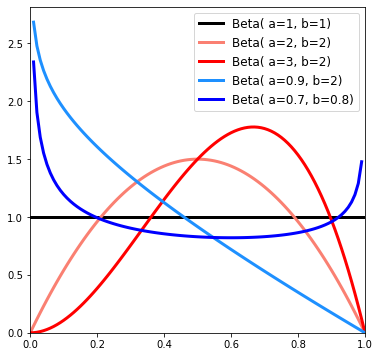

In [ ]:
pyplot.figure(figsize=(6,6))
example_dist=Beta()
xmin,xmax=0,1
xvals=numpy.linspace(xmin,xmax,101)
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=1,b=1)),c='black', lw=3, label='Beta( a=1, b=1)')
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=2,b=2)),c='salmon', lw=3, label='Beta( a=2, b=2)')
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=3,b=2)),c='r', lw=3, label='Beta( a=3, b=2)')
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=.9,b=2)),c='dodgerblue', lw=3, label='Beta( a=0.9, b=2)')
pyplot.plot(xvals,numpy.exp(example_dist.logp(xvals,a=.7,b=0.8)),c='blue', lw=3, label='Beta( a=0.7, b=0.8)')




pyplot.ylim(0)
pyplot.legend(fontsize=12)
xlim=pyplot.xlim(xmin,xmax)

## Distributions on a simplex

In [ ]:
#export 

def dirichlet_logpdf(x, alpha):
    try: 
        logprob=jsc.stats.dirichlet.logpdf(x.T,alpha=alpha)
    except:
        try: 
            logprob=jsc.stats.dirichlet.logpdf(x,alpha=alpha)
        except:
            raise ValueError('Dirichlet shape not consistent with alphas')
    return logprob
        
    
class Dirichlet(Distribution):
    def __init__(self, *args, **kwargs):
        """The Dirichlet distribution. Uses the scipy parameterization"""
        super().__init__(logp=dirichlet_logpdf,
                         rvs=scipy.stats.dirichlet.rvs,
                         bijection=Simplex())
        

## Discrete

In [ ]:
#export
class Bernoulli(Distribution):
    def __init__(self,*args, **kwargs):
        """The Bernoulli distribution. Uses the scipy parameterization"""
        super().__init__(logp=jsc.stats.bernoulli.logpmf,
                         rvs=scipy.stats.bernoulli.rvs,
                         lowerbound=0,
                        upperbound=1)
        

In [ ]:
#export

def categorical_logpmf(x,p):
    return (x*jnp.log(p)).sum(axis=-1)
#     return jsc.special.logsumexp(jnp.log(p),b=x,axis=-1)

class Categorical(Distribution):
    def __init__(self,*args, **kwargs):
        """The categorical distribution."""
        super().__init__(logp=categorical_logpmf,
                         rvs=None,
                         lowerbound=0,
                        upperbound=1)
        

In [ ]:
categorical_logpmf(numpy.ones(10)[:,None]*numpy.array([0,1,0]),numpy.ones(10)[:,None]* numpy.array([.1,.3,.6]))

DeviceArray([-1.2039728, -1.2039728, -1.2039728, -1.2039728, -1.2039728,
             -1.2039728, -1.2039728, -1.2039728, -1.2039728, -1.2039728],            dtype=float32)

In [ ]:
scipy.stats.multinomial.logpmf(numpy.array([0,1,0]), p=numpy.array([.1,.3,.6]),n=1, )

array(-1.2039728)

In [ ]:
#export
@jit
def binom_logpmf(x, n, p):
    """The binomial logpmf.
    ****
    **Arguments:**
    
    `x` (int, >=0) - The observation
    
    `n` (int, must be greater than 0) - The number of bernoulli trials
    
    `p` (float 0<p<1) - The success probability of the Bernoulli trials
    
    ****
    **Returns:** The log probability"""


    return (chooseln(n, x)+
            x*jnp.log(p)+(n-x)*jnp.log1p(-p))

class Binomial(Distribution):
    def __init__(self, *args, **kwargs):
        """The Binomial distribution. Uses the scipy parameterization"""
        
        super().__init__(logp=binom_logpmf,
                         rvs=scipy.stats.binom.rvs,
                         lowerbound=0,
                        upperbound=1)
        

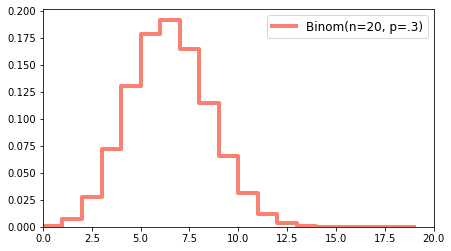

In [ ]:
pyplot.figure(figsize=(7,4))

example_dist=Binomial()
xmin,xmax=0,20
xvals=numpy.arange(0,xmax)
pyplot.step(xvals,numpy.exp(example_dist.logp(xvals,n=20,p=.3)),where='post',c='salmon', lw=4, label='Binom(n=20, p=.3)')
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)

pyplot.legend(fontsize=12)
xlim=pyplot.xlim(xmin,xmax)

In [ ]:
#export


class BetaBinomial(Distribution):
    def __init__(self, *args, **kwargs):
        """The beta-binomial distribution."""
        super().__init__(logp=jsc.stats.betabinom.logpmf,
                         rvs=scipy.stats.betabinom.rvs,
                         lowerbound=0,
                        upperbound=1)
        

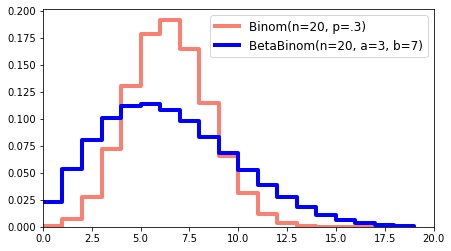

In [ ]:
pyplot.figure(figsize=(7,4))

example_dist=Binomial()
xmin,xmax=0,20
xvals=numpy.arange(0,xmax)
pyplot.step(xvals,numpy.exp(example_dist.logp(xvals,n=20,p=.3)),where='post',c='salmon', lw=4, label='Binom(n=20, p=.3)')
pyplot.ylim(0)
pyplot.xlim(xmin,xmax)
example_dist=BetaBinomial()
xmin,xmax=0,20
xvals=numpy.arange(0,xmax)
pyplot.step(xvals,numpy.exp(example_dist.logp(xvals,n=20,a=3, b=7)),where='post',c='blue', lw=4, label='BetaBinom(n=20, a=3, b=7)')

# pyplot.step(xvals,numpy.exp(example_dist.logp(xvals,mu=5, disp=3)),where='post',c='blue', lw=5, label='NegBinom(mu=5, disp=3)')
# pyplot.ylim(0)
pyplot.legend(fontsize=12)
xlim=pyplot.xlim(xmin,xmax)

In [ ]:
#export

@jit
def dirichlet_multinomial_logpmf(x,n,a):
    """Dirichlet-multinomial log pmf.
    
    ****
    **Arguments:**
    
    x (array): The data, last dimension should match the simplex
    n (array): The should match sum of the data along the last dimension
    a (array): The Dirichlet concentration parametes. The last dimension should\
    match the simplex.
    
    ****
    **Returns:** The log-probability mass"""
    a_sum=numpy.sum(a,-1)
    norm_constant=gammaln(a_sum)+gammaln(n+1)-gammaln(n+a_sum)
    density=gammaln(x+a)-gammaln(a)-gammaln(x+1)
    return norm_constant + jnp.sum(density,-1)
        
    
class DirichletMultinomial(Distribution):
    def __init__(self, *args, **kwargs):
        """Dirichlet-multinomial distribution"""
        
        super().__init__(logp=dirichlet_multinomial_logpmf,
                         rvs=None,
                         lowerbound=0,
                        upperbound=1)

### Tranformations of random variables

There are two ways of transforming variables that I think are worth distinguishing. 

    1. Transformations that do not impact the log-evidence
    2. Transformations that do impact the log-evidence
    
In most ways these transformations are equivalent. This distinction is what we intend a transformation to mean.

#### Deterministic transformations

First we might wish to describe our prior beliefs on some quantity with a particular distribution. But our domain knowledge tells us that it is some transformation of this quantity that influences the data we might observe. For example, an unrealistally simple example might look like this:

$$w \sim Normal(0, 1)$$
$$z = \mu+\sigma w$$

Here we want our prior beliefs to be described by $w \sim Normal(0, 1)$, so only this should contribute to the model's log-evidence. If we wrote this model 

In [ ]:
from amppl.model import Model, ModelBase

mu=0
sd=3

@Model
class SimpleTransformation(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        w=self.Normal('w', loc=0, scale=1)
        z=mu+sd*w

our model would not keep track of the value of $z$. If we want to track it, we can use a `Deterministic` RV to do so.

In [ ]:
@Model
class SimpleTransformation(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        w=self.Normal('w', loc=0, scale=1)
        z=self.Deterministic('z',value=mu+sd*w)

In [ ]:
#export
        
class Deterministic(Distribution):
    """Keeps track of the value and adds 0 to the log-evidence."""
    def __init__(self, *args, **kwargs):
        super().__init__(logp=lambda x:jnp.zeros(1),
                         rvs=None,)
        


### Correcting the log-evidence for changes of variable

But the shifting and rescaling of a normal random sample also follows a normal distribution. If 

$$w \sim Normal(0, 1)$$

then

$$\mu + \sigma w \sim Normal (\mu, \sigma)$$

So Approaches 1 and 2 are equivalent when describing the distribution of samples from these distributions. Let's plot this for $\mu=0$ and $\sigma =3$:

If we wanted to say that our prior belieifs about $z$ follow a normal distribution with mean $\mu$ and standard deviation $\sigma$, we could of course write

$$z \sim Normal (\mu, \sigma)$$

That would be the simplist way of doing so. However, we might also use th transformation described in the previous section to mean the same thing:

$$w \sim Normal(0, 1)$$
$$z = \mu+\sigma w$$

The second approach may seem a bit odd, but it is a useful way of writing the first distribution, especially in hierarchical models, because it can remove difficult to explore geometries from the model space. Let's take a look at how these transformation affect samples from normal distributions





/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


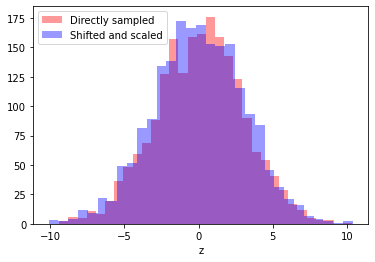

In [ ]:
mu=0
sd=3
z1=scipy.stats.norm.rvs(loc=mu, scale=sd, size=2000)

w2=scipy.stats.norm.rvs(loc=0, scale=1, size=2000)
z2=mu+sd*w2

seaborn.distplot(z1,kde=False, color='red',label='Directly sampled')
seaborn.distplot(z2,kde=False, color='blue',label='Shifted and scaled')
pyplot.xlabel('z')
pyplot.legend()

The distribution of the two samples is nearly identical. However, the shifted and scaled version (Approach 2) is somewhat ambiguous as written, and it could be read in two very different ways. A scaled and shifted sample from a normal distribution may follow a normal distribution, but in terms of their probability density functions, 

$$\frac{z-\mu}{\sigma} \sim Normal (0,1)$$

is not equivalent to 

$$z \sim Normal(\mu, \sigma)$$

Before explaining this with math, let's just compute the two log-probabilities. First, let's define the two models for $mu=4$ and $\sigma =3$ 

In [ ]:

mu=0
sd=3

@Model
class Approach1(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        z=self.Normal('z', loc=mu, scale=sd)

@Model
class Approach2(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        w=self.Normal('w', loc=0, scale=1)
        z=self.Deterministic('z',value=mu+sd*w)

Now let's evaluate the log-probability of each at $z=0$

In [ ]:
print (f"Approach 1, the probability of zero is {Approach1.set_state_and_evaluate(x=jnp.zeros(1))}")
print (f"Approach 2, the probability of zero is  {Approach2.set_state_and_evaluate(x=jnp.zeros(1))}")

Approach 1, the probability of zero is -2.0175509452819824
Approach 2, the probability of zero is  -0.9189385175704956


These are different. This because transformations of random variables stretch and/or contract the associated probability distributions. If we want

$$w \sim Normal(0, 1)$$
$$z = \mu+\sigma w$$

to mean the same log-probability as

$$z \sim Normal (\mu, \sigma)$$

we need to correct the probabilities. 

#### The gory details

To see how we need to correct this, we need to consider their log-probabilities. The normal distribution's log-probability is

$$log [N(x;\mu,\sigma)]=\frac{(x-\mu)^2}{2\sigma^2} - \frac{1}{2}log(2\pi) - \log(\sigma)$$

For the unit normal distribution, this simplifies to

$$log [N(x;0,1)]=\frac{x^2}{2} - \frac{1}{2}log(2\pi) - \log(1)=\frac{x^2}{2} - \frac{1}{2}log(2\pi) $$

So if we substitute in $x=\frac{z-\mu}{\sigma} $ we have

$$log [N(\frac{z-\mu}{\sigma};\mu,\sigma)]=\frac{(\frac{z-\mu}{\sigma})^2}{2} - \frac{1}{2}log(2\pi)$$

which can be rearranged as 

$$log [N(\frac{z-\mu}{\sigma};\mu,\sigma)]=\frac{(z-\mu)^2}{2\sigma^2} - \frac{1}{2}log(2\pi)$$

On the other hand, the log-probability corresponding to $$z \sim Normal(\mu, \sigma)$$ is

$$log [N(z;\mu,\sigma)]=\frac{(z-\mu)^2}{2\sigma^2} - \frac{1}{2}log(2\pi) - \log(\sigma)$$

These differ by the term $- \log(\sigma)$, which corresponds to how much the probability density at $w$ was stretched when it was converted to $z$ by the transformation $\mu+\sigma w$.

#### Less long, less gory

The two log-probabilities should differ by the negative log of the standard deviation ($-log(3)$):

In [ ]:
print (-numpy.log(3))
print (Approach1.set_state_and_evaluate(x=jnp.zeros(1))-Approach2.set_state_and_evaluate(x=jnp.zeros(1)))

-1.0986122886681098
-1.0986124


### Adjustment of the log-evidence (manually accounting for this)

One approach to fixing this would be to apply a manual adjust to model using adje

In [ ]:
#export
# class Adjustment(Distribution):
#     def __init__(self,adjustment, *args, **kwargs):
#         self.adjustment=adjustment
#         def logp(x,*args,**kwargs ):
#             return self.adjustment(x, *args, **kwargs)
#         super().__init__(logp=logp, rvs=None,)  
class Adjustment(Distribution):
    def __init__(self, *args, **kwargs):
        
        def logp(x,*args,**kwargs ):
            return x
        super().__init__(logp=logp, rvs=None,)  


In [ ]:
def correction(x):
    return -jnp.log(x)
    

@Model
class AdjustedModel(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        w=self.Normal('w', loc=0, scale=1)
        z=self.Deterministic('z',value=mu+sd*w)
        z_adj=self.AdjustEvidence('z_adj',value=correction(sd) )

In [ ]:
import inspect

In [ ]:
inspect.isclass(AdjustedModel)

False

In [ ]:
hasattr(AdjustedModel, '__init__')

True

Let's see if the adjusted model is equivalent to the first approach:

In [ ]:
print (f"Approach 1, the probability of zero is {Approach1.set_state_and_evaluate(x=jnp.zeros(1))}")
print (f"Approach 2, the probability of zero is  {AdjustedModel.set_state_and_evaluate(x=jnp.zeros(1))}")

Approach 1, the probability of zero is -2.0175509452819824
Approach 2, the probability of zero is  -2.0175509452819824


It is, but this is a little more complicated to be generally useful. That is, any time we wish to reparameterize a distribution like this, we need to figure out the appropriate correction. Myself, I'm not all that great at math, so I'd prefer to simply be able to define the transformation and have a computer do the work.

### Automatically accounting for this with TransformedRV

In general, the appropriate correcting is the log of the transformation's Jacobian determinant. Which is a mouthful, but JAX includes functions for automically computing the Jacobian of Python functions, and if the Jacobian is a matrix we can use `numpy.linalg.det` to get us the determinant. These are used by `TransformedRV` to automatically apply this correction for a particular transformation to the log-evidence. 


In [ ]:
#export
from inspect import signature
class TransformedRV(Distribution):
    def __init__(self, transformation, in_axes=None, *args, **kwargs):
        self.param_order=list(signature(transformation).parameters.keys())
        if isinstance(in_axes, type(None)):
            mapping=self._define_mapping()
#         print (mapping)
        else:
            mapping=in_axes
        self.__name__='transformedRV'
        self.transformation=jax.jit(transformation)
        self.jacobian=jax.jacfwd(transformation,argnums=0)
        self.vmap_jacobian= jax.vmap(self.jacobian,in_axes=mapping)
        
        
        def logp( x,*args, **kwargs):
#             print (x)
            
            args=self.kwarg2arg(args,kwargs)
#             if len(args)!=self.num_args:
#                 self.num_args=
#             if args==():
#                 if isinstance(x, float):
#                     jac_det=self.jacobian(x)  
#                 elif len(x.shape)==1:
#                     jac_det=self.vmap_jacobian(x)
#                 else:
#                     jac_det= jnp.linalg.det(self.vmap_jacobian(x ))
#     #             print(jac_det)
#             else:
            if isinstance(x, float):
                jac_det=self.jacobian(x,*args)  
            elif len(x.shape)==1:
                jac_det=self.vmap_jacobian(x,*args)
            else:
#                 jac_det=self.vmap_jacobian(x,*args)
                jac_det= jnp.linalg.det(self.vmap_jacobian(x,*args, ))
    #           
            return -jnp.log(jac_det)
        super().__init__(logp=logp, rvs=None,)        
#         super().__init__(logp=lambda val : jnp.linalg.det(self.jacobian(val)), rvs=None,)

    def _define_mapping(self):
        self.num_args=len(self.param_order)
        in_axes=[0]+[None]*(self.num_args-1)
        return in_axes
        
    def value(self, value, *args, **kwargs):
        return self.transformation(value, *args, **kwargs)
    
    def kwarg2arg(self,args, kwargs ):
#         print (args)
#         print (kwargs)
        if kwargs=={}:
            return args

#         print (self.param_order)
        new_params=[]
        for k in self.param_order[1:]:
            new_params.append(kwargs[k])
#         print (new_params)
        return tuple(new_params)
        
        

        



In [ ]:
inspect.isclass(TransformedRV)

NameError: name 'inspect' is not defined

I need to work out the rules for handling inputs with shapes.

To do this, we need to define the transformation as a function, and then pass this to the `transformation` of `TransformedRV`.

In [ ]:
def noncentered_normal(x, m,s):
    return m+s*x
    

@Model
class TransformedModel(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        w=self.Normal('w', loc=0, scale=1)
        z=self.TransformedRV('z',transformation=noncentered_normal, value=w, m=mu, s=sd)

NameError: name 'Model' is not defined

In [ ]:
print (f"TransformedMOdel, the probability of zero is  {TransformedModel.set_state_and_evaluate(x=jnp.zeros(1))}")

TransformedMOdel, the probability of zero is  -2.0175509452819824


In [ ]:
print (f"Approach 1, the probability of zero is {Approach1.set_state_and_evaluate(x=jnp.zeros(1))}")
print (f"Adjusted model, the probability of zero is  {AdjustedModel.set_state_and_evaluate(x=jnp.zeros(1))}")
print (f"TransformedMOdel, the probability of zero is  {TransformedModel.set_state_and_evaluate(x=jnp.zeros(1))}")

Approach 1, the probability of zero is -2.0175509452819824
Adjusted model, the probability of zero is  -2.0175509452819824
TransformedMOdel, the probability of zero is  -2.0175509452819824


In [ ]:
#export
class DistributionDefinitions():
    def __init__(self):
        """Defines the distributions that will be accessable from ModelBase"""
        
        
        #Create instances of the available distributions
        #A better way of doing this would be to specify the class, but then create an
        #instance of the class when each RV is first called. Why didn't I do that?
        #How hard would it be to change this?
        self._normal=Normal
#         self._logistic=Logistic
        
        self._spike_and_slab_norm=SpikeAndSlabNormal
        
        self._flat=Flat
        self._beta=Beta
        self._dirichlet=Dirichlet
        self._bernoulli=Bernoulli
        self._categorical=Categorical
        
        self._gamma=Gamma
        self._expon=Expon
        self._halfflat=HalfFlat
        self._halfnormal=HalfNormal
        self._halfstudentT=HalfStudentT
        self._poisson=Poisson
        self._studentT=StudentT
        self._multivariate_normal=MultivariateNormal
        self._cholesky_multivariate_normal=CholeskyMvNormal
        self._deterministic=Deterministic
        self._nbinom=NegativeBinomial
        self._invgamma=InverseGamma
        self._binomial=Binomial
        self._betabinom=BetaBinomial
        self._dirichletmultinomial=DirichletMultinomial
        self._gengamma=GenGamma
        self._invgengamma=InvGenGamma
#         self._skewedT=SkewedStudentT
#         self._quasiuniform=QuasiUniform
        self._hybridgengamma=HybridGenGamma
#         self._mixture=Mixture
#         self._finiteweibullscalemixture=FiniteWeibullScaleMixture
#         self._skeweddistribution=SkewedDistribution
#         self._sigmoidproduct=SigmoidProductDistribution
        
        

        #This lets us define distributions using strings
        self.distributions={'normal':self._normal,
#                             'logistic':self._logistic,
                            'flat':self._flat,
                           'gamma':self._gamma,
                            'bernoulli':self._bernoulli,
                            'categorical':self._categorical,
                           'exponential':self._expon,
                            'poisson':self._poisson,
                            'studentt':self._studentT,
                            'negativebinomial':self._nbinom,
                            'halfflat':self._halfflat,
                            'halfnormal':self._halfnormal,
                            'halfstudentt':self._halfstudentT,
                            'beta':self._beta,
                            'dirichlet':self._dirichlet,
                           'multivariatenormal':self._multivariate_normal,
                            'choleskymultivariatenormal':self._cholesky_multivariate_normal,
                           'deterministic':self._deterministic,
                           'inversegamma':self._invgamma,
                           'binomial': self._binomial,
                           'betabinom': self._betabinom,
                            'dirichletmultinomial': self._dirichletmultinomial,
                           'gengamma':self._gengamma,
                           'invgengamma':self._invgengamma,
#                            'skewedstudentt':self._skewedT,
                           'spikeandslabnormal':self._spike_and_slab_norm,
#                            'quasiuniform': self._quasiuniform,
                            'hybridgengamma':self._hybridgengamma,
                            #Mixture distributions
#                             'mixture':self._mixture,
#                             'finiteweibullscalemixture': self._finiteweibullscalemixture,
                            #Transformations
#                             'skeweddistribution':self._skeweddistribution,
#                             'sigmoidproduct':self._sigmoidproduct
                            
                           }
    
    #These give us the option of defining random variables using the distribution names. 
    
    def Normal(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._normal, value=value, shape=shape, *args, **kwargs)
#     def Logistic(self,name, value=None, shape=1, *args, **kwargs):
#         return self.RV(name=name,dist=self._logistic, value=value, shape=shape, *args, **kwargs)
   
#     def QuasiUniform(self,name, value=None, shape=1, *args, **kwargs):
#         return self.RV(name=name,dist=self._quasiuniform, value=value, shape=shape, *args, **kwargs)
    
    def SpikeAndSlabNormal(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._spike_and_slab_norm, value=value, shape=shape, *args, **kwargs)
    
    def StudentT(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._studentT, value=value, shape=shape, *args, **kwargs)
    
    def Flat(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._flat, value=value, shape=shape, *args, **kwargs)
    
    def HalfFlat(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._halfflat, value=value, shape=shape, *args, **kwargs)
    
    def HalfNormal(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._halfnormal, value=value, shape=shape, *args, **kwargs)
    
    def HalfStudentT(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._halfstudentT, value=value, shape=shape, *args, **kwargs)
    
#     def SkewedStudentT(self,name, value=None, shape=1, *args, **kwargs):
#         return self.RV(name=name,dist=self._skewedT, value=value, shape=shape, *args, **kwargs)
    
    def Poisson(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._poisson, value=value, shape=shape, *args, **kwargs)
    
    def Binomial(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._binomial, value=value, shape=shape, *args, **kwargs)
    
    def BetaBinomial(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._betabinom, value=value, shape=shape, *args, **kwargs)
    
    def DirichletMultinomial(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._dirichletmultinomial, value=value, shape=shape, *args, **kwargs)
        
    def Gamma(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._gamma, value=value, shape=shape, *args, **kwargs)
    def GenGamma(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._gengamma, value=value, shape=shape, *args, **kwargs)
    def HybridGenGamma(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._hybridgengamma, value=value, shape=shape, *args, **kwargs)
    
    def InvGenGamma(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._invgengamma, value=value, shape=shape, *args, **kwargs)
    
    def InverseGamma(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._invgamma, value=value, shape=shape, *args, **kwargs)
    
    def Exponential(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._expon, value=value, shape=shape, *args, **kwargs)
    
    def Beta(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._beta, value=value, shape=shape, *args, **kwargs)
    
    def Dirichlet(self,name, value=None, shape=(1,1), *args, **kwargs):
        return self.RV(name=name,dist=self._dirichlet, value=value, shape=shape, *args, **kwargs)

    def Categorical(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._categorical, value=value, shape=shape, *args, **kwargs)
    
    def Bernoulli(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._bernoulli, value=value, shape=shape, *args, **kwargs)
    
    def MultivariateNormal(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._multivariate_normal, value=value, shape=shape, *args, **kwargs)
    
    def CholeskyMvNormal(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,dist=self._cholesky_multivariate_normal, value=value, shape=shape, *args, **kwargs)
    
    def Deterministic(self,name, value, shape=1, *args, **kwargs):
        """Defines some value and keep track of it, but does not modify the log-evidence"""
#         assert value!=None, "Deterministic variables must have a defined value"
        return self.RV(name=name,dist=self._deterministic, value=value, shape=shape, *args, **kwargs)

    def NegativeBinomial(self,name, value=None, shape=1, *args, **kwargs):
        return self.RV(name=name,
                       dist=self._nbinom, 
                       value=value, 
                       shape=shape, 
                       *args, 
                       **kwargs)
        
    def AdjustEvidence(self,name, value=None, shape=1, *args, **kwargs):
        """Adjust the log-evidence using function defined by `adjustment`. This is useful
        if you transform a random variable and want this to reflect a parameterization. 
        `TransformedRV` would generally be preferable, as it uses JAX to compute the appropriate
        correction, but in some cases manually adjusting the log-evidence may be simpler"""
        dist=Adjustment
        return self.RV(name=name, 
                       dist=dist, 
                       value=value,
                       shape=shape,
                       *args, 
                       **kwargs)
    
#     def TransformedRV(self, name, value, transformation,shape=1,in_axes=None, *args, **kwargs):
#         """Transforms a random variable, returning the result and adjusting the model's log-evidence
#         with the log of the the transformation's Jacobian determinant. This correction reflects how the
#         transformation stretches/compresses the probability density."""
#         if hasattr(self, 'transformation_dict')==False:
#             self.transformation_dict={}
#         if name not in self.transformation_dict:
#             self.transformation_dict[name]=TransformedRV(transformation, in_axes=in_axes)
        
#         return self.RV(name=name,dist=self.transformation_dict[name], value=value, shape=shape, *args, **kwargs)
    
    def TransformedRV(self, name, value, transformation,shape=1,in_axes=None, *args, **kwargs):
        """Transforms a random variable, returning the result and adjusting the model's log-evidence
        with the log of the the transformation's Jacobian determinant. This correction reflects how the
        transformation stretches/compresses the probability density."""
#         if hasattr(self, 'transformation_dict')==False:
#             self.transformation_dict={}
#         if name not in self.transformation_dict:
#             self.transformation_dict[name]=TransformedRV(transformation, in_axes=in_axes)
#         self.transformation_dict[name].__name__='TransformedRV'
        
        return self.RV(name=name,dist=TransformedRV(transformation=transformation,
                                                    in_axes=in_axes), value=value, shape=shape, 
                       *args, **kwargs)
#         return self.RV(name=name,dist=TransformedRV, value=value, shape=shape,in_axes=in_axes, transformation=transformation, *args, **kwargs)

#     def Mixture(self,name, value=None, shape=1, *args, **kwargs):
#         return self.RV(name=name,dist=self._mixture, value=value, shape=shape, *args, **kwargs)

#     def FiniteWeibullScaleMixture(self, name, value=None, shape=1, *args, **kwargs):
#         return self.RV(name=name,dist=self._finiteweibullscalemixture, value=value, shape=shape, *args, **kwargs)
    
#     def SkewedDistribution(self, name, value=None, shape=1, *args, **kwargs):
#         return self.RV(name=name,dist=self._skeweddistribution, value=value, shape=shape, *args, **kwargs)
    
#     def SigmoidProductDistribution(self, name, value=None, shape=1, *args, **kwargs):
#         return self.RV(name=name,dist=self._sigmoidproduct, value=value, shape=shape, *args, **kwargs)
        
#     def ComponentDistribution(self,name,RV, shape=1, *args, **kwargs):
#         """This creates a component distribution for mixture models"""
#         if hasattr(self, 'component_dict')==False:
#             self.component_dict={}
#         if name not in self.component_dict:
#             self.component_dict[name]=ComponentDistribution(name,RV,shape, *args,**kwargs)
#         else: #Update the arguments
#             self.component_dict[name].args=args
#             self.component_dict[name].kwargs=kwargs
#         return self.component_dict[name]
    
#     def Mixture(self,name, value=None,dists=[], shape=1, wts=[], *args, **kwargs):
        

        
#         if hasattr(self, 'mixture_dict')==False:
#             self.mixture_dict={}
#         if name not in self.mixture_dict:
#             lower, upper=None, None
#             for i, comp_dist in enumerate(dists):
#                 comp_name=comp_dist.name
#                 comp_args=comp_dist.args
#                 comp_kwargs=comp_dist.kwargs
#                 null_value=comp_dist.RV(name=comp_name, comp_dist=True)
#                 if isinstance(lower, type(None))&isinstance(lower, type(None)):
#                     lower=self.RVs[comp_name].distribution.lowerbound
#                     upper=self.RVs[comp_name].distribution.upperbound
#                 else:
#                     assert lower==self.RVs[comp_name].distribution.lowerbound, "All component distributions must have the same support"
#                     assert upper==self.RVs[comp_name].distribution.upperbound, "All component distributions must have the same support"
            
#             def logp(x, wts,comp_logp, comp_args, comp_kwargs):
#                 comp_logevid=jnp.zeros((len(wts), len(value)))
#                 lower,upper
#                 for i, logp_func in enumerate(comp_logp):
                    
#                     args=comp_args[i]
#                     kwargs=comp_kwargs[i]
#     #                 null_value=comp_dist.RV()
#                     comp_logevid[i,:]+=logp_func(x, *args, **kwargs)+wts[i]
                
#                 return jsc.special.logsumexp(comp_logevid, axis=0)
            
#             self.mixture_dict[name]=Distribution(logp=logp, lowerbound=lower, upperbound=upper)
            
#             comp_logp=[]
#             comp_args=[]
#             comp_kwargs=[]
#             for i, comp_dist in enumerate(dists):
#                 comp_name=comp_dist.name
#                 comp_logp=self.RVs[comp_name].distribution.logp
#                 comp_args.append(comp_dist.args)
#                 comp_kwargs.append(comp_dist.kwargs)
#         return self.RV(name=name,dist=self.mixture_dict[name], value=value, shape=shape, wts=wts, comp_logp=comp_logp, comp_args=comp_args,
#                       comp_kwargs=comp_kwargs)
#         #Now call all of the ComponentDistributions, but with the values fixed
#         # to the param_values. This will prevent stored parameters from being created
